Welcome to the Team 7 Project One!

We are trying to answer the question: "Does proximity to a metro influence a residence's price in Arlington?"

Methodology:
- We used Arlington Country property tax assessments as a proxy for home price
- We calculated each residence's distance to all 11 metro stations in Arlington, VA
- We used the Google Maps API to geocode the latitude and longitude of each metro and residence
- We used the haversine equation to calculate the absolute distance between the two locations
- We randomly selected 10,000 residences for our final data to reduce the number of API calls we needed to make

Findings: Matt and Aimal ADD THESE
    
!!! Notes to the USER !!!
- The use of the haversine equation requires installing the MPU library
- There are two data calls for the Google Maps API - it is ok to skip these cells and move to the next
    if the associated .csv files are available in your folder

In [9]:
%matplotlib notebook

In [113]:
# INSTALL if you dont already have mpu library
# !pip install mpu --user

# Dependencies
import requests
import json
import pandas as pd
import numpy as np
from pprint import pprint
import time
#import mpu
#import gmaps
import matplotlib.pyplot as plt

# Google developer API key
from config import gkey

# Read in Arlington County Housing Assessment data
arl_data = pd.read_csv("2018_Arl_Asmt.csv")

print(f'The original data set has {len(arl_data)} addresses.')

The original data set has 37708 addresses.


In [114]:
# Clean arl_data set - remove commercial, assessment changes, public housing, etc. to create shortlist of residences
short_list = arl_data[arl_data["PropertyClassTypeCode"].isin([511,512,513,514,515,611,612,613,616,630])] 
short_list = short_list[short_list['AssessmentChangeReasonTypeDsc'].isin(['01- Annual'])]
short_list.drop(short_list[short_list['CommercialInd'] == True].index, inplace=True)
short_list = short_list[pd.isnull(short_list['TaxExemptionTypeDsc'])]
short_list = short_list[short_list['TotalAssessedAmt'] > 70000]  
short_list['State']='VA'

# Slim down the dataset to required columns
house_list = short_list[["PropertyStreetNbrNameText",
                        "PropertyCityName",
                        "State", 
                        "PropertyZipCode",
                        "TotalAssessedAmt"]]

print(f'The cleaned data set has {len(house_list)} addresses.')

The cleaned data set has 32680 addresses.


In [115]:
house_list.head(2)

,PropertyStreetNbrNameText,PropertyCityName,State,PropertyZipCode,TotalAssessedAmt
1,3007 N ROCHESTER ST,ARLINGTON,VA,22213,1772500
2,6547 WILLIAMSBURG BLVD,ARLINGTON,VA,22213,773000


In [116]:
# Reduce number of properties in sample to 10,000 to limit API calls
house_list_sorted=house_list.sort_values(['TotalAssessedAmt'], ascending=False)
sample_house_list=house_list_sorted.sample(10000)
sample_house_list.reset_index(drop=True, inplace=True)
sample_house_list.head(2)

,PropertyStreetNbrNameText,PropertyCityName,State,PropertyZipCode,TotalAssessedAmt
0,4845 16th ST N,ARLINGTON,VA,22205,760300
1,1305 N TUCKAHOE ST,ARLINGTON,VA,22205,405700


In [20]:
# # ### SKIP this cell if you do not want to use google maps API and go to next cell (using existing csv file) ###

# # Get the latitude and longitude of each residence
# params = {"key": gkey}

# try:
#     for index, row in sample_house_list[0:10000].iterrows():
#         base_url = "https://maps.googleapis.com/maps/api/geocode/json"

#         street = row["PropertyStreetNbrNameText"]
#         city = row["PropertyCityName"]
#         state = row["State"]
#         zip = row["PropertyZipCode"]

#         params['address'] = f"{street},{city},{state},{zip}"

#         houses_lat_lng = json.loads(requests.get(base_url, params=params).content)
#         current_lat = houses_lat_lng["results"][0]["geometry"]["location"]["lat"]
#         current_lng = houses_lat_lng["results"][0]["geometry"]["location"]["lng"]

#         sample_house_list.loc[index, "Lat"] = current_lat
#         sample_house_list.loc[index, "Lng"] = current_lng
        
#         time.sleep(.02)

# except KeyError:
#     pass

# sample_house_list.to_csv('house_list_latlng.csv')
# sample_house_list.head()

In [117]:
len(sample_house_list)

10000

In [118]:
# Creating a csv file to hold the results from the API query - 10,000 residences with their latitudes and longitudes
final_house_list = pd.read_csv("house_list_latlng.csv")
final_house_list = final_house_list.drop(['Unnamed: 0'], axis=1)
final_house_list.head(20)

,PropertyStreetNbrNameText,PropertyCityName,State,PropertyZipCode,TotalAssessedAmt,Lat,Lng
0,5512 WILLIAMSBURG BLVD,ARLINGTON,VA,22207,838200,38.906584,-77.147505
1,419 N NORWOOD ST,ARLINGTON,VA,22203,881000,38.876819,-77.102423
2,505 N MANCHESTER ST,ARLINGTON,VA,22203,685000,38.871423,-77.133731
3,4102 11th ST N,ARLINGTON,VA,22201,657500,38.883899,-77.109887
4,3708 5th ST S,ARLINGTON,VA,22204,825000,38.866453,-77.097340
5,1761 N TROY ST 09445,ARLINGTON,VA,22201,275500,38.894129,-77.082901
6,969 S TAYLOR ST,ARLINGTON,VA,22204,414800,38.858939,-77.103558
7,1639 N WOODSTOCK ST,ARLINGTON,VA,22207,766300,38.890869,-77.119999
8,3355 S STAFFORD ST,ARLINGTON,VA,22206,529400,38.834302,-77.085917
9,1637 N BUCHANAN ST,ARLINGTON,VA,22207,767900,38.890152,-77.122561


In [23]:
# Created a list of all metro stations in Arlington from WMATA website
metro_list = pd.DataFrame(
   {'metro': ['Arlington Cemetery','Ballston MU','Clarendon','Court House','Crystal City','East Falls Church','Pentagon','Pentagon City','Ronald Reagan Washington National Airport','Rosslyn','Virginia Square GMU'],
    'street': ['1000 North Memorial Drive', '4230 Fairfax Drive', '3100 Wilson Blvd', '2100 Wilson Blvd', '1750 South Clark St.', '2001 N. Sycamore St.', '2 South Rotary Road', '1250 South Hayes St.', '2400 S. Smith Blvd.', '1850 N. Moore Street', '3600 Fairfax Drive'],
    'city': ['Arlington', 'Arlington', 'Arlington', 'Arlington', 'Arlington', 'Arlington', 'Arlington', 'Arlington', 'Arlington', 'Arlington', 'Arlington'],
    'state': ['VA', 'VA', 'VA', 'VA', 'VA', 'VA', 'VA', 'VA', 'VA', 'VA', 'VA'],
    'zip': ['22211', '22201', '22201', '22201', '22202', '22205', '22202', '22202', '22202', '22209', '22201']
   })

metro_list["lat"] = ""
metro_list["lng"] = ""

metro_list.head()

,metro,street,city,state,zip,lat,lng
0,Arlington Cemetery,1000 North Memorial Drive,Arlington,VA,22211,,
1,Ballston MU,4230 Fairfax Drive,Arlington,VA,22201,,
2,Clarendon,3100 Wilson Blvd,Arlington,VA,22201,,
3,Court House,2100 Wilson Blvd,Arlington,VA,22201,,
4,Crystal City,1750 South Clark St.,Arlington,VA,22202,,


In [ ]:
# ### SKIP this cell if you do not want to use google maps API and go to next cell (using existing csv file) ###

# # Get the latitude and longitude of each metro station
# params = {"key": gkey}

# for index, row in metro_list.iterrows():
#     base_url = "https://maps.googleapis.com/maps/api/geocode/json"

#     street = row['street']
#     city = row['city']
#     state = row['state']
#     zip = row['zip']

#     params['address'] = f"{street},{city},{state},{zip}"

#     metros_lat_lng = requests.get(base_url, params=params)
#     metros_lat_lng = metros_lat_lng.json()

#     metro_list.loc[index, "lat"] = metros_lat_lng["results"][0]["geometry"]["location"]["lat"]
#     metro_list.loc[index, "lng"] = metros_lat_lng["results"][0]["geometry"]["location"]["lng"]

# metro_list.to_csv('metro_list_latlng.csv')
# metro_list.head(2)

In [119]:
# Creating a csv file to hold the results from the API query - 11 metro stations with their latitudes and longitudes
metro_list_latlng = pd.read_csv('metro_list_latlng.csv')
metro_list_latlng = metro_list_latlng.drop(['Unnamed: 0'], axis=1)
metro_list_latlng.head(2)

,metro,street,city,state,zip,lat,lng
0,Arlington Cemetery,1000 North Memorial Drive,Arlington,VA,22211,38.884564,-77.063173
1,Ballston MU,4230 Fairfax Drive,Arlington,VA,22201,38.881964,-77.111477


In [25]:
# Creating a map featuring each metro station
coordinates = metro_list_latlng[["lat", "lng"]]

# Customize the size of the figure
figure_layout = {
    'width': '800px',
    'height': '600px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'
}
metro_fig = gmaps.figure(layout=figure_layout)

# Assign the marker layer to a variable
markers = gmaps.marker_layer(coordinates)

# Add the layer to the map
metro_fig.add_layer(markers)

metro_fig

NameError: name 'gmaps' is not defined

In [ ]:
# # Confirm lat lng formatted correctly for use in haversine equation
# metro_list_latlng.lat = metro_list.lat.astype(float)
# metro_list_latlng.lng = metro_list.lng.astype(float)
# final_house_list.Lat = final_house_list.Lat.astype(float)
# final_house_list.Lng = final_house_list.Lng.astype(float)

# # Use haversine equation to calc absolute distance between each metro and residence pair in miles
# distance = []
# house_lat = []
# house_lng = []

# for i, r in metro_list.iterrows():
#     final_house_list[r["metro"]] = "0.00"
    
# for i in range (0, 11):
#     metro_lat = metro_list_latlng['lat'][i]
#     metro_lng = metro_list_latlng['lng'][i]
#     name = metro_list_latlng["metro"][i]
    
#     for i, r in final_house_list.iterrows():
        
#         house_lat = r["Lat"]
#         house_lng = r["Lng"]
         
#         dist = mpu.haversine_distance((metro_lat, metro_lng), (house_lat, house_lng))
#         conversion_factor = 0.621371
#         dist = dist * conversion_factor
        
#         r[name] = dist
        
#         final_house_list.at[i, name] = dist

# final_house_dist = final_house_list
# final_house_dist.head(2)

In [ ]:
# # Calculate the shortest distance between a residence and the metros
# final_house_dist['MinDistance'] = final_house_dist[["Arlington Cemetery", "Ballston MU", "Clarendon", "Court House", "Crystal City", "East Falls Church", "Pentagon", "Pentagon City", "Ronald Reagan Washington National Airport", "Rosslyn", "Virginia Square GMU"]].min(axis=1)
# final_house_dist.head(2)

In [120]:
# Save final house list with minimum distance as file and read in as dataset
# final_house_dist.to_csv('final_house_distMin.csv')
final_house_distMin = pd.read_csv('final_house_distMin.csv')
final_house_distMin = final_house_distMin.drop(['Unnamed: 0'], axis=1)
final_house_distMin.head(2)

,PropertyStreetNbrNameText,PropertyCityName,State,PropertyZipCode,TotalAssessedAmt,Lat,Lng,Arlington Cemetery,Ballston MU,Clarendon,Court House,Crystal City,East Falls Church,Pentagon,Pentagon City,Ronald Reagan Washington National Airport,Rosslyn,Virginia Square GMU,MinDistance
0,5512 WILLIAMSBURG BLVD,ARLINGTON,VA,22207,838200,38.906584,-77.147505,4.783354,2.578264,3.116943,3.524145,6.171499,1.534449,5.50460,5.580234,6.840147,4.116377,2.879752,1.534449
1,419 N NORWOOD ST,ARLINGTON,VA,22203,881000,38.876819,-77.102423,2.177857,0.602949,0.808582,1.388182,3.037570,2.960807,2.53236,2.466866,3.685585,2.144117,0.417955,0.417955


In [27]:
# Store 'Lat' and 'Lng' from final_house_distMin data frame into  locations 
locations = final_house_distMin[["Lat", "Lng"]].astype(float)

# Create heatmap layer
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, 
                                 dissipating=True, max_intensity=5,
                                 point_radius = 1)

fig.add_layer(heat_layer)

fig

NameError: name 'gmaps' is not defined

In [28]:

fig = gmaps.figure(map_type="HYBRID")

heat_layer = gmaps.heatmap_layer(locations,
                                 dissipating=True, max_intensity=5,
                                 point_radius=1)

fig.add_layer(heat_layer)
fig.add_layer(markers)

fig

NameError: name 'gmaps' is not defined

In [29]:
# Create bins in which to place values based upon assessment value
#bins = [0, 100000, 200000, 300000, 400000, 500000,
        600000, 700000, 800000, 900000, 1000000, 110000000]

# Create labels for these bins
#group_labels = ["0 to 100k", "100k to 200k", "200k to 300k", "300k to 400k", "400k to 500k", "500k to 600k",
                "600k to 700k", "700k to 800k", "800k to 900k", "900k to 1mil", "1mil+"]

In [30]:
# Slice the data and place it into bins
#pd.cut(final_house_distMin["TotalAssessedAmt"], bins, labels=group_labels).head()

0    800k to 900k
1    800k to 900k
2    600k to 700k
3    600k to 700k
4    800k to 900k
Name: TotalAssessedAmt, dtype: category
Categories (11, object): [0 to 100k < 100k to 200k < 200k to 300k < 300k to 400k ... 700k to 800k < 800k to 900k < 900k to 1mil < 1mil+]

In [31]:
# Place the data series into a new column inside of the DataFrame
#final_house_distMin["Assessment Category"] = pd.cut(final_house_distMin["TotalAssessedAmt"], bins, labels=group_labels)
#final_house_distMin.head()

,PropertyStreetNbrNameText,PropertyCityName,State,PropertyZipCode,TotalAssessedAmt,Lat,Lng,Arlington Cemetery,Ballston MU,Clarendon,Court House,Crystal City,East Falls Church,Pentagon,Pentagon City,Ronald Reagan Washington National Airport,Rosslyn,Virginia Square GMU,MinDistance,Assessment Category
0,5512 WILLIAMSBURG BLVD,ARLINGTON,VA,22207,838200,38.906584,-77.147505,4.783354,2.578264,3.116943,3.524145,6.171499,1.534449,5.504600,5.580234,6.840147,4.116377,2.879752,1.534449,800k to 900k
1,419 N NORWOOD ST,ARLINGTON,VA,22203,881000,38.876819,-77.102423,2.177857,0.602949,0.808582,1.388182,3.037570,2.960807,2.532360,2.466866,3.685585,2.144117,0.417955,0.417955,800k to 900k
2,505 N MANCHESTER ST,ARLINGTON,VA,22203,685000,38.871423,-77.133731,3.902256,1.401162,2.336881,2.973055,4.511228,1.555734,4.184239,4.002513,5.084223,3.757434,1.805207,1.401162,600k to 700k
3,4102 11th ST N,ARLINGTON,VA,22201,657500,38.883899,-77.109887,2.512833,0.158724,0.818639,1.445296,3.624269,2.500659,3.035693,3.040309,4.285561,2.226528,0.350483,0.158724,600k to 700k
4,3708 5th ST S,ARLINGTON,VA,22204,825000,38.866453,-77.097340,2.223419,1.314067,1.430729,1.859353,2.527425,3.434653,2.248393,2.016668,3.122574,2.504581,1.177869,1.177869,800k to 900k


In [32]:
# Create a GroupBy object based upon "Assessment Category"
#asmt_group = final_house_distMin.groupby("Assessment Category")

<IPython.core.display.Javascript object>


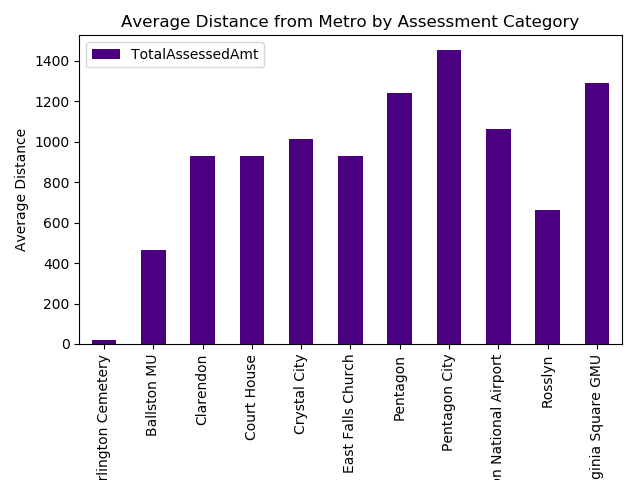

In [33]:
#asmt_count = (asmt_group[["TotalAssessedAmt"]].count())

#asmt_count_chart = asmt_count.plot(kind="bar", color = "indigo", title="Number of Houses by Assessment Category")
#asmt_count_chart.set_xlabel("Assessment Categories")
#asmt_count_chart.set_ylabel("Number of Houses")

#plt.show()
#plt.tight_layout()

In [34]:
#plt.savefig("NumHouseAsmt.png")

<IPython.core.display.Javascript object>


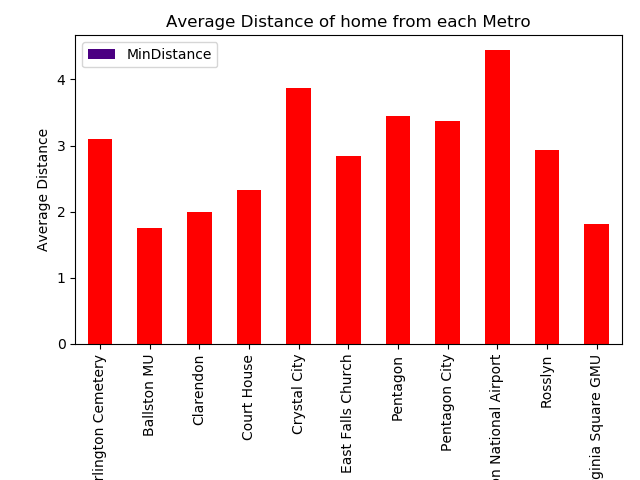

In [69]:
#distance_mean = (asmt_group[["MinDistance"]].mean())

#distance_mean_chart = distance_mean.plot(kind="bar", color = "indigo", title="Average Distance from Metro by Assessment Category")
#distance_mean_chart.set_xlabel("Assessment Categories")
#distance_mean_chart.set_ylabel("Average Distance")

#plt.show()
#plt.tight_layout()

In [ ]:
#plt.savefig("AvgDistAsmt.png")

KeyError: 'Assessment Categories'

In [121]:
Metro_mean=final_house_distMin[["Arlington Cemetery", "Ballston MU", "Clarendon", "Court House", "Crystal City", "East Falls Church", "Pentagon", "Pentagon City", "Ronald Reagan Washington National Airport", "Rosslyn", "Virginia Square GMU"]].mean()
print (Metro_mean)

Arlington Cemetery                           3.098471
Ballston MU                                  1.757221
Clarendon                                    1.992988
Court House                                  2.334529
Crystal City                                 3.865253
East Falls Church                            2.834359
Pentagon                                     3.448541
Pentagon City                                3.371735
Ronald Reagan Washington National Airport    4.444008
Rosslyn                                      2.927802
Virginia Square GMU                          1.812876
dtype: float64


In [128]:
Metro_mean_chart=Metro_mean.plot(kind="bar", color = "red", title="Average Distance of home from each Metro")
Metro_mean_chart.set_xlabel("Station")
Metro_mean_chart.set_ylabel("Average Distance")
plt.show()

In [123]:
final_house_distMin['Min']=final_house_distMin[['Arlington Cemetery', 'Ballston MU', 'Clarendon', 'Court House', 'Crystal City', 'East Falls Church', 'Pentagon', 'Pentagon City', 'Ronald Reagan Washington National Airport',
                                                'Rosslyn', 'Virginia Square GMU']].idxmin(axis=1)
final_house_distMin.head()

,PropertyStreetNbrNameText,PropertyCityName,State,PropertyZipCode,TotalAssessedAmt,Lat,Lng,Arlington Cemetery,Ballston MU,Clarendon,Court House,Crystal City,East Falls Church,Pentagon,Pentagon City,Ronald Reagan Washington National Airport,Rosslyn,Virginia Square GMU,MinDistance,Min
0,5512 WILLIAMSBURG BLVD,ARLINGTON,VA,22207,838200,38.906584,-77.147505,4.783354,2.578264,3.116943,3.524145,6.171499,1.534449,5.504600,5.580234,6.840147,4.116377,2.879752,1.534449,East Falls Church
1,419 N NORWOOD ST,ARLINGTON,VA,22203,881000,38.876819,-77.102423,2.177857,0.602949,0.808582,1.388182,3.037570,2.960807,2.532360,2.466866,3.685585,2.144117,0.417955,0.417955,Virginia Square GMU
2,505 N MANCHESTER ST,ARLINGTON,VA,22203,685000,38.871423,-77.133731,3.902256,1.401162,2.336881,2.973055,4.511228,1.555734,4.184239,4.002513,5.084223,3.757434,1.805207,1.401162,Ballston MU
3,4102 11th ST N,ARLINGTON,VA,22201,657500,38.883899,-77.109887,2.512833,0.158724,0.818639,1.445296,3.624269,2.500659,3.035693,3.040309,4.285561,2.226528,0.350483,0.158724,Ballston MU
4,3708 5th ST S,ARLINGTON,VA,22204,825000,38.866453,-77.097340,2.223419,1.314067,1.430729,1.859353,2.527425,3.434653,2.248393,2.016668,3.122574,2.504581,1.177869,1.177869,Virginia Square GMU


In [124]:
Min_group = final_house_distMin.groupby("Min")

<IPython.core.display.Javascript object>


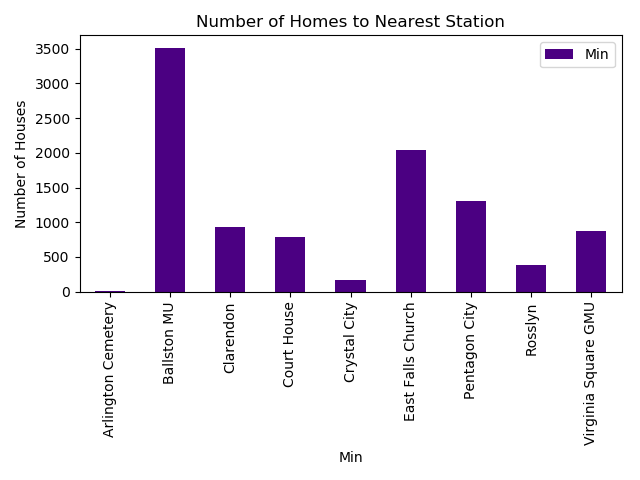

In [135]:
Min_count = (Min_group[["Min"]].count())

Min_count_chart = Min_count.plot(kind="bar", color = "indigo", title="Number of Homes to Nearest Station")
Min_count_chart.set_xlabel("Min")
Min_count_chart.set_ylabel("Number of Houses")

plt.show()
plt.tight_layout()

In [136]:
plt.savefig("HomestoStation.png")

<IPython.core.display.Javascript object>


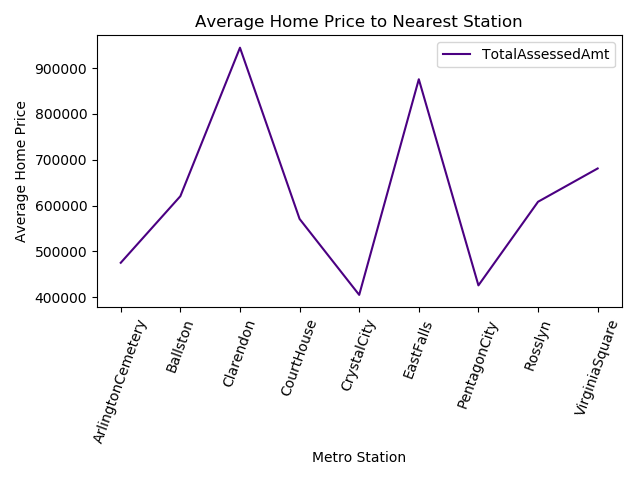

In [179]:
Min_count = (Min_group[["TotalAssessedAmt"]].mean())

Min_count_chart = Min_count.plot(kind="line", color = "indigo", title="Average Home Price to Nearest Station")
plt.xticks(np.arange(9), ('ArlingtonCemetery', 'Ballston', 'Clarendon', 'CourtHouse', 'CrystalCity', 'EastFalls', 'PentagonCity', 'Rosslyn', 'VirginiaSquare'))
plt.xlabel("Metro Station")
plt.ylabel("Average Home Price")
plt.xticks(rotation=70)

plt.show()
plt.tight_layout()

In [181]:
plt.savefig("AverPricevsStation.png")